In [73]:
# Import required libraries and dependencies
import pandas as pd
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Load the data into a Pandas DataFrame
df_market_data = pd.read_csv(
    "Resources/crypto_market_data.csv",
    index_col="coin_id")

# Display sample data
df_market_data.head(5)

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
bitcoin,1.08388,7.60278,6.57509,7.67258,-3.25185,83.51840,37.51761
ethereum,0.22392,10.38134,4.80849,0.13169,-12.88890,186.77418,101.96023
tether,-0.21173,0.04935,0.00640,-0.04237,0.28037,-0.00542,0.01954
ripple,-0.37819,-0.60926,2.24984,0.23455,-17.55245,39.53888,-16.60193
bitcoin-cash,2.90585,17.09717,14.75334,15.74903,-13.71793,21.66042,14.49384


In [25]:
# Generate summary statistics
df_market_data.describe()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,-0.269686,4.497147,0.185787,1.545693,-0.094119,236.537432,347.667956
std,2.694793,6.375218,8.376939,26.344218,47.365803,435.225304,1247.842884
min,-13.527860,-6.094560,-18.158900,-34.705480,-44.822480,-0.392100,-17.567530
25%,-0.608970,0.047260,-5.026620,-10.438470,-25.907990,21.660420,0.406170
50%,-0.063410,3.296410,0.109740,-0.042370,-7.544550,83.905200,69.691950
75%,0.612090,7.602780,5.510740,4.578130,0.657260,216.177610,168.372510
max,4.840330,20.694590,24.239190,140.795700,223.064370,2227.927820,7852.089700


In [26]:
df_market_data.shape

(41, 7)

In [27]:
# Plot your data to see what's in your DataFrame
df_market_data.hvplot.line(
    width=800,
    height=400,
    rot=90
)

:NdOverlay   [Variable]
   :Curve   [coin_id]   (value)

---

### Prepare the Data

In [28]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
crypto_market_scaled = StandardScaler().fit_transform(df_market_data[["price_change_percentage_24h", "price_change_percentage_7d", "price_change_percentage_14d","price_change_percentage_30d", "price_change_percentage_60d", "price_change_percentage_200d",  "price_change_percentage_1y"]])
                                                  


In [29]:
# Create a DataFrame with the scaled data
df_crypto_scaled = pd.DataFrame(crypto_market_scaled, columns = ["price_change_percentage_24h", "price_change_percentage_7d", "price_change_percentage_14d","price_change_percentage_30d", "price_change_percentage_60d", "price_change_percentage_200d",  "price_change_percentage_1y"])

# Copy the crypto names from the original data
df_crypto_scaled["coin_id"] = df_market_data.index
# Set the coinid column as index
df_crypto_scaled = df_crypto_scaled.set_index("coin_id")

# Display sample data
df_crypto_scaled.head()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y
coin_id,,,,,,,
bitcoin,0.508529,0.493193,0.772200,0.235460,-0.067495,-0.355953,-0.251637
ethereum,0.185446,0.934445,0.558692,-0.054341,-0.273483,-0.115759,-0.199352
tether,0.021774,-0.706337,-0.021680,-0.061030,0.008005,-0.550247,-0.282061
ripple,-0.040764,-0.810928,0.249458,-0.050388,-0.373164,-0.458259,-0.295546
bitcoin-cash,1.193036,2.000959,1.760610,0.545842,-0.291203,-0.499848,-0.270317


---

### Find the Best Value for k Using the Original Data.

In [30]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1,11))

In [31]:
# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_market_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    model = KMeans(n_clusters = i, random_state = 1)
    model.fit(df_crypto_scaled)
    inertia.append(model.inertia_)

In [32]:
# Create a dictionary with the data to plot the Elbow curve
elbow_crypto_data = {
    "k": k,
    "inertia": inertia
}

# Create a DataFrame with the data to plot the Elbow curve
df_elbow_crypto = pd.DataFrame(elbow_crypto_data)

In [40]:
df_elbow_crypto

,k,inertia
0,1,287.000000
1,2,195.820218
2,3,123.190482
3,4,79.022435
4,5,63.858668
5,6,53.057788
6,7,44.406791
7,8,37.078233
8,9,32.832187
9,10,28.165433


In [33]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_plot_crypto = df_elbow_crypto.hvplot.line(x = "k", y="inertia", title = "Elbow Curve Using Crypto Data", xticks = k)
elbow_plot_crypto

:Curve   [k]   (inertia)

#### Answer the following question: 

**Question:** What is the best value for `k`?

**Answer: Based on the Elbow Curve, the best value for k looks like 4, i.e, K=4 .

---

### Cluster Cryptocurrencies with K-means Using the Original Data

In [11]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters = 4)

In [12]:
# Fit the K-Means model using the scaled data
model.fit(df_crypto_scaled)

In [34]:
# Predict the clusters to group the cryptocurrencies using the scaled data
crypto_clusters = model.predict(df_crypto_scaled)

# Print the resulting array of cluster values.
print(crypto_clusters)

[1 1 3 3 7 1 9 9 1 3 6 3 3 7 3 1 3 3 9 3 6 1 3 3 3 3 3 6 1 5 3 3 4 1 0 8 2
 6 1 3 6]


In [35]:
# Create a copy of the DataFrame
df_crypto_predictions = df_crypto_scaled.copy()

In [36]:
# Add a new column to the DataFrame with the predicted clusters
df_crypto_predictions["CryptoClusters"] = crypto_clusters

# Display sample data
df_crypto_predictions.head()

,price_change_percentage_24h,price_change_percentage_7d,price_change_percentage_14d,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y,CryptoClusters
coin_id,,,,,,,,
bitcoin,0.508529,0.493193,0.772200,0.235460,-0.067495,-0.355953,-0.251637,1
ethereum,0.185446,0.934445,0.558692,-0.054341,-0.273483,-0.115759,-0.199352,1
tether,0.021774,-0.706337,-0.021680,-0.061030,0.008005,-0.550247,-0.282061,3
ripple,-0.040764,-0.810928,0.249458,-0.050388,-0.373164,-0.458259,-0.295546,3
bitcoin-cash,1.193036,2.000959,1.760610,0.545842,-0.291203,-0.499848,-0.270317,7


In [69]:
# Create a scatter plot using hvPlot by setting 
# `x="price_change_percentage_24h"` and `y="price_change_percentage_7d"`. 
# Color the graph points with the labels found using K-Means and 
# add the crypto name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.
scatter_plot = df_crypto_predictions.hvplot.scatter(
    x = "price_change_percentage_24h",
    y = "price_change_percentage_7d",
    by = "CryptoClusters",
    hover_cols=["coin_id"],
    cmap='Category10',  
    title='Crypto Price Change'
)

# Render the plot
scatter_plot

:NdOverlay   [CryptoClusters]
   :Scatter   [price_change_percentage_24h]   (price_change_percentage_7d,coin_id)

---

### Optimize Clusters with Principal Component Analysis.

In [42]:
# Create a PCA model instance and set `n_components=3`.
pca = PCA(n_components=3)

In [43]:
# Use the PCA model with `fit_transform` to reduce to 
# three principal components.
crypto_pca = pca.fit_transform(df_crypto_predictions)
# View the first five rows of the DataFrame. 
crypto_pca[:5]

array([[-2.59802461, -0.61049215,  0.8703502 ],
       [-2.53690606, -0.46759568,  0.48345997],
       [-0.7586813 , -0.43731012, -0.15684767],
       [-0.77400862, -0.47623602, -0.21107011],
       [ 3.50977265, -1.13947793,  1.99940886]])

In [45]:
# Retrieve the explained variance to determine how much information 
# can be attributed to each principal component.
pca.explained_variance_ratio_

array([0.46671458, 0.20134547, 0.18779686])

#### Answer the following question: 

**Question:** What is the total explained variance of the three principal components?

**Answer:** The total explained variance of the three principal components is 0.8558 which means that when we add together the explained variance ratios of the three principal components (46.67%, 20.13%, and 18.78%), we get a total of approximately 85.58%.It indicates that a significant portion of the variability in the dataset can be captured by these three principal components.

In [47]:
# Create a new DataFrame with the PCA data.
# Creating a DataFrame with the PCA data
crypto_pca_df = pd.DataFrame(crypto_pca, columns = ["PC1", "PC2", "PC3"])

# Copy the crypto names from the original data
crypto_pca_df["coin_id"] = df_crypto_predictions.index

# Set the coinid column as index
crypto_pca_df = crypto_pca_df.set_index("coin_id")

# Display sample data
crypto_pca_df.head()

,PC1,PC2,PC3
coin_id,,,
bitcoin,-2.598025,-0.610492,0.870350
ethereum,-2.536906,-0.467596,0.483460
tether,-0.758681,-0.437310,-0.156848
ripple,-0.774009,-0.476236,-0.211070
bitcoin-cash,3.509773,-1.139478,1.999409


---

### Find the Best Value for k Using the PCA Data

In [48]:
# Create a list with the number of k-values from 1 to 11
k = list(range(1,11))

In [49]:
# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_market_data_pca`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters = i, random_state = 1)
    k_model.fit(crypto_pca_df)
    inertia.append(k_model.inertia_)

In [50]:
# Create a dictionary with the data to plot the Elbow curve
elbow_crypto_pca = { "k" : k, "inertia": inertia}
# Create a DataFrame with the data to plot the Elbow curve
df_elbow_crypto_pca = pd.DataFrame(elbow_crypto_pca)

In [51]:
# Review the DataFrame
df_elbow_crypto_pca.head()

,k,inertia
0,1,453.792035
1,2,258.299888
2,3,173.962222
3,4,103.268761
4,5,65.699444


In [54]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
df_elbow_crypto_pca.hvplot.line(
    x = "k",
    y = "inertia",
    title = "Elbow Curve",
    xticks = k
)

:Curve   [k]   (inertia)

#### Answer the following questions: 

* **Question:** What is the best value for `k` when using the PCA data?

  * **Answer:** The best value for 'k' when using PCA data is 6.


* **Question:** Does it differ from the best k value found using the original data?

  * **Answer:** Yes I found a difference in finding the best k value with  original data and PCA data.

### Cluster Cryptocurrencies with K-means Using the PCA Data

In [61]:
crypto_pca_df.head()

,PC1,PC2,PC3
coin_id,,,
bitcoin,-2.598025,-0.610492,0.870350
ethereum,-2.536906,-0.467596,0.483460
tether,-0.758681,-0.437310,-0.156848
ripple,-0.774009,-0.476236,-0.211070
bitcoin-cash,3.509773,-1.139478,1.999409


In [58]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters = 6, random_state = 0)

In [59]:
# Fit the K-Means model using the PCA data
model.fit(crypto_pca_df)

KMeans(n_clusters=6, random_state=0)

In [62]:
# Predict the clusters to group the cryptocurrencies using the PCA data
crypto_6 = model.predict(crypto_pca_df)

# Print the resulting array of cluster values.
crypto_6[:5]

array([3, 3, 0, 0, 2])

In [64]:
# Create a copy of the DataFrame with the PCA data
crypto_6_pca__predictions_df = crypto_pca_df.copy()

# Add a new column to the DataFrame with the predicted clusters
crypto_6_pca__predictions_df["Crypto Clusters"] = crypto_6

# Display sample data
crypto_6_pca__predictions_df.head()

,PC1,PC2,PC3,Crypto Clusters
coin_id,,,,
bitcoin,-2.598025,-0.610492,0.870350,3
ethereum,-2.536906,-0.467596,0.483460,3
tether,-0.758681,-0.437310,-0.156848,0
ripple,-0.774009,-0.476236,-0.211070,0
bitcoin-cash,3.509773,-1.139478,1.999409,2


In [67]:
# Create a scatter plot using hvPlot by setting 
# `x="PC1"` and `y="PC2"`. 
# Color the graph points with the labels found using K-Means and 
# add the crypto name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.
crypto_6_pca__predictions_df.hvplot.scatter(
    x = "PC1",
    y = "PC2",
    by = "Crypto Clusters"
)

:NdOverlay   [Crypto Clusters]
   :Scatter   [PC1]   (PC2)

### Visualize and Compare the Results

In this section, you will visually analyze the cluster analysis results by contrasting the outcome with and without using the optimization techniques.

In [74]:
# Composite plot to contrast the Elbow curves
# Step 1: Compute distortion scores and plot elbow curves
def compute_distortion_scores(X, k_values):
    distortion_scores = []
    for k in k_values:
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(X)
        distortion_scores.append(model.inertia_)
    return distortion_scores

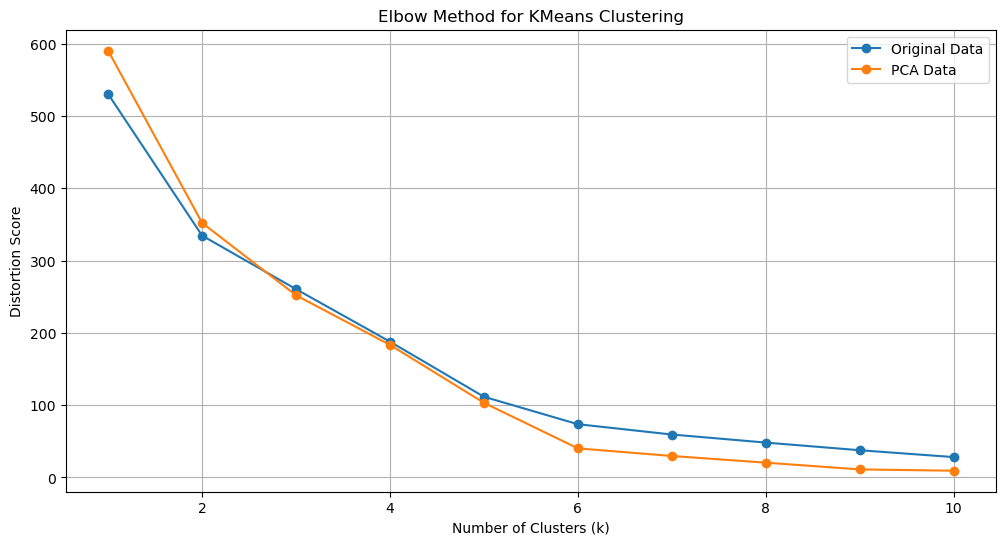

In [75]:
# Choose the range of k values for elbow method
k_values = range(1, 11)

# Compute distortion scores for both datasets
distortion_scores_original = compute_distortion_scores(df_crypto_predictions, k_values)
distortion_scores_pca = compute_distortion_scores(crypto_6_pca__predictions_df, k_values)

# Plot distortion scores
plt.figure(figsize=(12, 6))

# Plot for original data
plt.plot(k_values, distortion_scores_original, marker='o', label='Original Data')

# Plot for PCA data
plt.plot(k_values, distortion_scores_pca, marker='o', label='PCA Data')

plt.title('Elbow Method for KMeans Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion Score')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
# Composite plot to contrast the clusters
# Plot cryptocurrency clusters resulting from the original data
original_cluster_plot = df_crypto_predictions.hvplot.scatter(x='price_change_percentage_24h', 
                                                             y='price_change_percentage_7d', 
                                                             by='CryptoClusters', 
                                                             hover_cols=['coin_id'], 
                                                             title='Original Data Clusters')

# Plot cryptocurrency clusters resulting from the PCA data
pca_cluster_plot = crypto_6_pca__predictions_df.hvplot.scatter(x='PC1', y='PC2', 
                                                               by='Crypto Clusters', 
                                                               hover_cols=['coin_id'], 
                                                               title='PCA Data Clusters')

# Combine both plots
composite_plot = original_cluster_plot + pca_cluster_plot

# Show the composite plot
composite_plot

:Layout
   .NdOverlay.I  :NdOverlay   [CryptoClusters]
      :Scatter   [price_change_percentage_24h]   (price_change_percentage_7d,coin_id)
   .NdOverlay.II :NdOverlay   [Crypto Clusters]
      :Scatter   [PC1]   (PC2,coin_id)

#### Answer the following question: 

  * **Question:** After visually analyzing the cluster analysis results, what is the impact of using fewer features to cluster the data using K-Means?

  * **Answer:** We can make some inferences about the impact of using fewer features (via PCA) to cluster the data using K-Means:
- Cluster Separation: In the PCA plot, the clusters appear to be more separated along the principal component axes compared to the original feature space. This is a common outcome of PCA, as it aims to maximize variance along its principal components, which can lead to better-defined clusters.
- Noise Reduction: PCA can also serve to reduce noise by eliminating components that contribute less to the variance. This might result in cleaner clusters that are easier for K-Means to identify.
In summary, the impact of using fewer features through PCA on K-Means clustering can include improved cluster separation, noise reduction, and potentially better clustering performance due to the reduction of dimensionality. However, it might also lead to the merging of some clusters and changes in cluster shapes, which could affect the interpretation of the clustering results.